<a href="https://colab.research.google.com/github/geadalfa/PrediksiWarna/blob/main/NN_Buat_Deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.dates as dates
from datetime import datetime
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt #untuk menampilkan gambar/grafik
import numpy as np #untuk operasi vektor dan matriks dengan mengolah array dan array multidimensi
import cv2 #library OpenCV untuk memanipulasi gambar
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os #untuk dapat berinteraksi dengan sist operasi
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None

%matplotlib inline

from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

#Import Dataset


In [ ]:
dataset = pd.read_excel('/content/drive/MyDrive/2017-2018-2019-2020-2021.xlsx')
dataset

,Color,hsv,hue,saturation,brightness,rgb,minggu ke,Ex. Factory Date,Model Long Descriptions,PO Number,Total PO Order Qty,kelas,kelas_2,Date,Year,Month,Season
0,CREAM,"(43.99999999999994, 6.329113924050635, 92.9411...",44.000000,6.329114,92.941176,[237 233 222],1,2017-07-09,ALTO VST-POLY FILL-VEST,4.700613e+09,3798,3.0,3.1,2017-07-09,2017,7,2
1,NAVY,"(240, 100, 50)",240.000000,100.000000,50.000000,[0 0 128],2,2017-07-12,ALTO VST-POLY FILL-VEST,4.700613e+09,9996,11.0,11.2,2017-07-12,2017,7,2
2,OLIVE,"(43.75, 54.54545454545454, 34.509803921568626)",43.750000,54.545455,34.509804,[88 75 40],3,2017-07-23,ALTO VST-POLY FILL-VEST,4.700613e+09,3798,3.0,3.1,2017-07-23,2017,7,2
3,BLACK,"(289.99999999999994, 9.836065573770492, 23.921...",290.000000,9.836066,23.921569,[60 55 61],4,2017-07-31,FAIRWAY JKT-SYNTHETIC-JACKET,4.700627e+09,514,17.0,17.1,2017-07-31,2017,7,2
4,BLACK,"(289.99999999999994, 9.836065573770492, 23.921...",290.000000,9.836066,23.921569,[60 55 61],1,2017-08-01,FAIRWAY JKT-SYNTHETIC-JACKET,4.700627e+09,10222,17.0,17.1,2017-08-01,2017,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,RED,"(349.94011976047904, 94.35028248587571, 69.411...",349.940120,94.350282,69.411765,[177 10 38],4,NaT,NaN,NaN,3430,NaN,NaN,NaT,2021,1,4
172,BLUE,"(225.88235294117646, 73.91304347826086, 36.078...",225.882353,73.913043,36.078431,[24 40 92],1,NaT,NaN,NaN,18,NaN,NaN,NaT,2021,2,4
173,NAVY,"(240, 100, 50)",240.000000,100.000000,50.000000,[0 0 128],2,NaT,NaN,NaN,4050,NaN,NaN,NaT,2021,2,4
174,NAVY,"(240, 100, 50)",240.000000,100.000000,50.000000,[0 0 128],3,NaT,NaN,NaN,3696,NaN,NaN,NaT,2021,2,4


# Preprocessing



In [ ]:
dataset['Color'].value_counts()

NAVY             50
BLACK            31
BLUE             19
GREY             19
MULTI            13
RED              12
SAPPHIRE STAR     9
WHITE             8
GREEN             5
BAKER RED         3
MANGO             2
OLIVE             2
PINK              1
CREAM             1
BLUE MIST         1
Name: Color, dtype: int64

In [ ]:
def fc(row):
    if row['Color'] =='BAKER RED':
        val = 1
    elif row['Color'] == 'BLACK' :
        val = 2
    # elif row['Color'] == 'BLACKWATCH PLAID' :
    #     val = 3
    elif row['Color'] == 'BLUE' :
        val = 3
    elif row['Color'] == 'BLUE MIST' :
        val = 4
    elif row['Color'] == 'CREAM' :
        val = 5
    elif row['Color'] == 'GREEN' :
        val = 6
    elif row['Color'] == 'GREY' :
        val = 7
    elif row['Color'] == 'MANGO' :
        val = 8
    elif row['Color'] == 'MULTI' :
        val = 9
    elif row['Color'] == 'NAVY' :
        val = 10
    elif row['Color'] == 'OLIVE' :
        val = 11
    elif row['Color'] == 'PINK' :
        val = 12
    elif row['Color'] == 'RED' :
        val = 13
    elif row['Color'] == 'SAPPHIRE STAR' :
        val = 14
    else:
        val = 15
    return val

dataset['color_int'] = dataset.apply(fc, axis=1)
dataset.head()

,Color,hsv,hue,saturation,brightness,rgb,minggu ke,Ex. Factory Date,Model Long Descriptions,PO Number,Total PO Order Qty,kelas,kelas_2,Date,Year,Month,Season,color_int
0,CREAM,"(43.99999999999994, 6.329113924050635, 92.9411...",44.00,6.329114,92.941176,[237 233 222],1,2017-07-09,ALTO VST-POLY FILL-VEST,4.700613e+09,3798,3.0,3.1,2017-07-09,2017,7,2,5
1,NAVY,"(240, 100, 50)",240.00,100.000000,50.000000,[0 0 128],2,2017-07-12,ALTO VST-POLY FILL-VEST,4.700613e+09,9996,11.0,11.2,2017-07-12,2017,7,2,10
2,OLIVE,"(43.75, 54.54545454545454, 34.509803921568626)",43.75,54.545455,34.509804,[88 75 40],3,2017-07-23,ALTO VST-POLY FILL-VEST,4.700613e+09,3798,3.0,3.1,2017-07-23,2017,7,2,11
3,BLACK,"(289.99999999999994, 9.836065573770492, 23.921...",290.00,9.836066,23.921569,[60 55 61],4,2017-07-31,FAIRWAY JKT-SYNTHETIC-JACKET,4.700627e+09,514,17.0,17.1,2017-07-31,2017,7,2,2
4,BLACK,"(289.99999999999994, 9.836065573770492, 23.921...",290.00,9.836066,23.921569,[60 55 61],1,2017-08-01,FAIRWAY JKT-SYNTHETIC-JACKET,4.700627e+09,10222,17.0,17.1,2017-08-01,2017,8,2,2


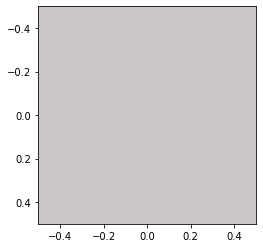

In [ ]:
import matplotlib.pyplot as plt
plt.imshow([[(203, 198, 199)]])
#rgb(893,446,-1785)

In [ ]:
dataset['color_int'].value_counts()

10    50
2     31
7     19
3     19
9     13
13    12
14     9
15     8
6      5
1      3
11     2
8      2
12     1
5      1
4      1
Name: color_int, dtype: int64

In [ ]:
dataset.dtypes

Color                              object
hsv                                object
hue                               float64
saturation                        float64
brightness                        float64
rgb                                object
minggu ke                           int64
Ex. Factory Date           datetime64[ns]
Model Long Descriptions            object
PO Number                         float64
Total PO  Order Qty                 int64
kelas                             float64
kelas_2                           float64
Date                       datetime64[ns]
Year                                int64
Month                               int64
Season                              int64
color_int                           int64
dtype: object

In [ ]:
df = dataset.astype({"Date": str})
df.dtypes

Color                              object
hsv                                object
hue                               float64
saturation                        float64
brightness                        float64
rgb                                object
minggu ke                           int64
Ex. Factory Date           datetime64[ns]
Model Long Descriptions            object
PO Number                         float64
Total PO  Order Qty                 int64
kelas                             float64
kelas_2                           float64
Date                               object
Year                                int64
Month                               int64
Season                              int64
color_int                           int64
dtype: object

In [ ]:
df = df.assign(tgl = df.Year.astype(str) + '' + df.Month.astype(str) + '' + df['minggu ke'].astype(str))
df['Date'].replace('-','', regex=True, inplace=True)
df

,Color,hsv,hue,saturation,brightness,rgb,minggu ke,Ex. Factory Date,Model Long Descriptions,PO Number,Total PO Order Qty,kelas,kelas_2,Date,Year,Month,Season,color_int,tgl
0,CREAM,"(43.99999999999994, 6.329113924050635, 92.9411...",44.000000,6.329114,92.941176,[237 233 222],1,2017-07-09,ALTO VST-POLY FILL-VEST,4.700613e+09,3798,3.0,3.1,20170709,2017,7,2,5,201771
1,NAVY,"(240, 100, 50)",240.000000,100.000000,50.000000,[0 0 128],2,2017-07-12,ALTO VST-POLY FILL-VEST,4.700613e+09,9996,11.0,11.2,20170712,2017,7,2,10,201772
2,OLIVE,"(43.75, 54.54545454545454, 34.509803921568626)",43.750000,54.545455,34.509804,[88 75 40],3,2017-07-23,ALTO VST-POLY FILL-VEST,4.700613e+09,3798,3.0,3.1,20170723,2017,7,2,11,201773
3,BLACK,"(289.99999999999994, 9.836065573770492, 23.921...",290.000000,9.836066,23.921569,[60 55 61],4,2017-07-31,FAIRWAY JKT-SYNTHETIC-JACKET,4.700627e+09,514,17.0,17.1,20170731,2017,7,2,2,201774
4,BLACK,"(289.99999999999994, 9.836065573770492, 23.921...",290.000000,9.836066,23.921569,[60 55 61],1,2017-08-01,FAIRWAY JKT-SYNTHETIC-JACKET,4.700627e+09,10222,17.0,17.1,20170801,2017,8,2,2,201781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,RED,"(349.94011976047904, 94.35028248587571, 69.411...",349.940120,94.350282,69.411765,[177 10 38],4,NaT,NaN,NaN,3430,NaN,NaN,NaT,2021,1,4,13,202114
172,BLUE,"(225.88235294117646, 73.91304347826086, 36.078...",225.882353,73.913043,36.078431,[24 40 92],1,NaT,NaN,NaN,18,NaN,NaN,NaT,2021,2,4,3,202121
173,NAVY,"(240, 100, 50)",240.000000,100.000000,50.000000,[0 0 128],2,NaT,NaN,NaN,4050,NaN,NaN,NaT,2021,2,4,10,202122
174,NAVY,"(240, 100, 50)",240.000000,100.000000,50.000000,[0 0 128],3,NaT,NaN,NaN,3696,NaN,NaN,NaT,2021,2,4,10,202123


In [ ]:
#df = df.astype({"Date": int})
#df = df.astype({"tgl": int})
#df.dtypes

In [ ]:
# Menghapus kelas
df.drop(columns=['kelas', 'kelas_2'], axis=1, inplace=True)
#df.head(2)

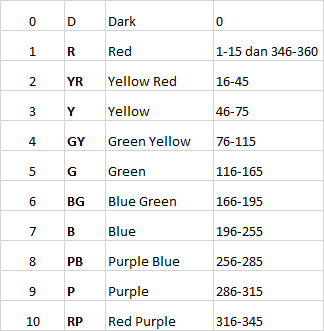

In [ ]:
# Menghapus kelas
dataset.drop(columns=['kelas', 'kelas_2'])
#df.head(2)

def rc(row):
    if row['hue'] < 0.5 :
        val = 0
    elif row['hue'] <= 15 :
        val = 1
    elif row['hue'] <= 45 :
        val = 2
    elif row['hue'] <= 75 :
        val = 3
    elif row['hue'] <= 115 :
        val = 4
    elif row['hue'] <= 165 :
        val = 5
    elif row['hue'] <= 195 :
        val = 6
    elif row['hue'] <= 255 :
        val = 7
    elif row['hue'] <= 285 :
        val = 8
    elif row['hue'] <= 315 :
        val = 9
    elif row['hue'] <= 345 :
        val = 10
    else:
        val = 1
    return val

dataset['range_warna'] = dataset.apply(rc, axis=1)
dataset.head(2)

,Color,hsv,hue,saturation,brightness,rgb,minggu ke,Ex. Factory Date,Model Long Descriptions,PO Number,Total PO Order Qty,kelas,kelas_2,Date,Year,Month,Season,color_int,range_warna
0,CREAM,"(43.99999999999994, 6.329113924050635, 92.9411...",44.0,6.329114,92.941176,[237 233 222],1,2017-07-09,ALTO VST-POLY FILL-VEST,4.700613e+09,3798,3.0,3.1,2017-07-09,2017,7,2,5,2
1,NAVY,"(240, 100, 50)",240.0,100.000000,50.000000,[0 0 128],2,2017-07-12,ALTO VST-POLY FILL-VEST,4.700613e+09,9996,11.0,11.2,2017-07-12,2017,7,2,10,7


In [ ]:
# decimals = 2    
# dataset['hue'] = dataset['hue'].apply(lambda x: round(x, decimals))
# dataset['saturation'] = dataset['saturation'].apply(lambda x: round(x, decimals))
# dataset['brightness'] = dataset['brightness'].apply(lambda x: round(x, decimals))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

x = dataset.drop(columns=['Color','hsv','kelas','kelas_2','Model Long Descriptions',
                          'PO Number','rgb','Ex. Factory Date','hue','Date','color_int'])
df3 = dataset.drop(columns=['Color','hsv','kelas','kelas_2','Model Long Descriptions',
                          'PO Number','rgb','Ex. Factory Date', 'Date','color_int'])
y = dataset['hue']

In [ ]:
df3.to_excel("variabelfix.xlsx")
#x.to_excel("trainvar.xlsx")

In [ ]:
print(x.columns)
#print(X.columns)
#print(X2.columns)
print(y)
#print(y)

Index(['saturation', 'brightness', 'minggu ke', 'Total PO  Order Qty', 'Year',
       'Month', 'Season', 'range_warna'],
      dtype='object')
0       44.000000
1      240.000000
2       43.750000
3      290.000000
4      290.000000
          ...    
171    349.940120
172    225.882353
173    240.000000
174    240.000000
175      0.000000
Name: hue, Length: 176, dtype: float64


In [ ]:
x

,saturation,brightness,minggu ke,Total PO Order Qty,Year,Month,Season,range_warna
0,6.329114,92.941176,1,3798,2017,7,2,2
1,100.000000,50.000000,2,9996,2017,7,2,7
2,54.545455,34.509804,3,3798,2017,7,2,2
3,9.836066,23.921569,4,514,2017,7,2,9
4,9.836066,23.921569,1,10222,2017,8,2,9
...,...,...,...,...,...,...,...,...
171,94.350282,69.411765,4,3430,2021,1,4,1
172,73.913043,36.078431,1,18,2021,2,4,7
173,100.000000,50.000000,2,4050,2021,2,4,7
174,100.000000,50.000000,3,3696,2021,2,4,7


# Neural Network Baru


In [ ]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle=False)
x_train.to_excel("x_trainVar.xlsx")
x_test.to_excel("x_testVar.xlsx")
y_train.to_excel("y_trainVar.xlsx")
y_test.to_excel("y_testVar.xlsx")

In [ ]:
y_test

140    290.000000
141    122.535211
142      0.000000
143    240.000000
144    225.882353
145    193.176471
146    240.000000
147    290.000000
148    290.000000
149    122.535211
150    240.000000
151    353.291925
152    240.000000
153    290.000000
154      0.000000
155    349.940120
156    240.000000
157    353.291925
158    290.000000
159    349.940120
160    193.176471
161    225.882353
162    225.882353
163    240.000000
164    240.000000
165    225.882353
166    193.176471
167      0.000000
168    240.000000
169      0.000000
170    290.000000
171    349.940120
172    225.882353
173    240.000000
174    240.000000
175      0.000000
Name: hue, dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_test1 = x_test
X_train = sc.fit_transform(x_train)
X_test = sc.fit_transform(x_test)

In [ ]:
import tensorflow as tf

# Early Stopping
custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=50, 
    min_delta=40, 
    mode='auto', verbose = 1
)

class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mse') <= 11):
      print("\mse telah mencapai < 11!")
      self.model.stop_training = True
myCallBack = myCallBack()

In [ ]:
model = Sequential()
model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

In [ ]:
history = model.fit(X_train, y_train, epochs=500, batch_size=2,  verbose=1, validation_split=0.1, callbacks=[myCallBack,custom_early_stopping])

Epoch 1/500
63/63 [==============================] - 1s 9ms/step - loss: 57237.9530 - mse: 57237.9530 - val_loss: 48542.5898 - val_mse: 48542.5898
Epoch 2/500
63/63 [==============================] - 0s 1ms/step - loss: 55083.4302 - mse: 55083.4302 - val_loss: 48391.7500 - val_mse: 48391.7500
Epoch 3/500
63/63 [==============================] - 0s 1ms/step - loss: 52600.7159 - mse: 52600.7159 - val_loss: 48196.6523 - val_mse: 48196.6523
Epoch 4/500
63/63 [==============================] - 0s 2ms/step - loss: 51914.4162 - mse: 51914.4162 - val_loss: 47944.1445 - val_mse: 47944.1445
Epoch 5/500
63/63 [==============================] - 0s 2ms/step - loss: 50547.0914 - mse: 50547.0914 - val_loss: 47635.9102 - val_mse: 47635.9102
Epoch 6/500
63/63 [==============================] - 0s 2ms/step - loss: 49090.7182 - mse: 49090.7182 - val_loss: 47264.2773 - val_mse: 47264.2773
Epoch 7/500
63/63 [==============================] - 0s 2ms/step - loss: 52696.3631 - mse: 52696.3631 - val_loss: 4682

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


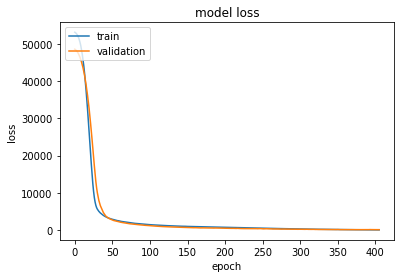

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

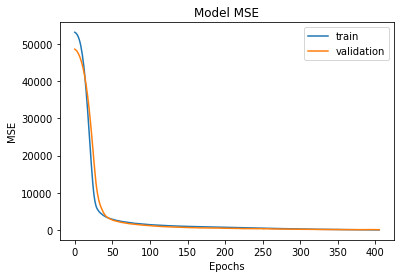

In [ ]:
# Menampilkan plot akurasi dari model
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
predictions = model.predict(X_test)
y_pred2 = np.minimum(360., np.maximum(0, model.predict(X_test)))

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions, squared=False)
rmse2 = mean_squared_error(y_test, y_pred2, squared=False)

print(rmse)
print(rmse2)

10.360295084196553
10.360295084196553


In [ ]:
predictions = predictions.tolist()
predictions = pd.Series(predictions)
predictions = predictions.explode()
print(predictions)

y_pred2 = y_pred2.tolist()
y_pred2 = pd.Series(y_pred2)
y_pred2 = y_pred2.explode()
print(y_pred2)

0     307.342
1     118.005
2     4.57884
3     237.789
4     238.766
5     188.729
6      237.98
7     305.091
8     307.049
9     119.004
10    238.124
11    337.496
12    237.944
13    309.961
14    2.43343
15    328.196
16     237.96
17    355.916
18    308.977
19    334.685
20    188.732
21    233.591
22    233.904
23    237.867
24    237.833
25    228.212
26    188.468
27    12.3809
28    236.843
29    10.4933
30    309.014
31    341.851
32    227.832
33    237.441
34    237.391
35    12.6516
dtype: object
0     307.342
1     118.005
2     4.57884
3     237.789
4     238.766
5     188.729
6      237.98
7     305.091
8     307.049
9     119.004
10    238.124
11    337.496
12    237.944
13    309.961
14    2.43343
15    328.196
16     237.96
17    355.916
18    308.977
19    334.685
20    188.732
21    233.591
22    233.904
23    237.867
24    237.833
25    228.212
26    188.468
27    12.3809
28    236.843
29    10.4933
30    309.014
31    341.851
32    227.832
33    237.441
34    

In [ ]:
y_test = y_test.reset_index(drop=True)
compare = pd.DataFrame({'hue' : y_test, 'pred' : predictions})
compare2 = pd.DataFrame({'hue' : y_test, 'pred' : y_pred2})
#compare = pd.DataFrame(y_test, y_pred, axis=1)

print(compare)
print(compare2)

           hue     pred
0   290.000000  307.342
1   122.535211  118.005
2     0.000000  4.57884
3   240.000000  237.789
4   225.882353  238.766
5   193.176471  188.729
6   240.000000   237.98
7   290.000000  305.091
8   290.000000  307.049
9   122.535211  119.004
10  240.000000  238.124
11  353.291925  337.496
12  240.000000  237.944
13  290.000000  309.961
14    0.000000  2.43343
15  349.940120  328.196
16  240.000000   237.96
17  353.291925  355.916
18  290.000000  308.977
19  349.940120  334.685
20  193.176471  188.732
21  225.882353  233.591
22  225.882353  233.904
23  240.000000  237.867
24  240.000000  237.833
25  225.882353  228.212
26  193.176471  188.468
27    0.000000  12.3809
28  240.000000  236.843
29    0.000000  10.4933
30  290.000000  309.014
31  349.940120  341.851
32  225.882353  227.832
33  240.000000  237.441
34  240.000000  237.391
35    0.000000  12.6516
           hue     pred
0   290.000000  307.342
1   122.535211  118.005
2     0.000000  4.57884
3   240.000000  

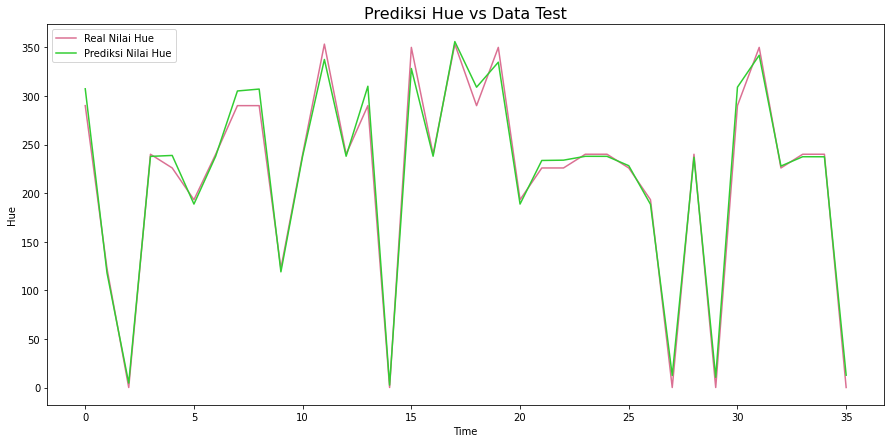

In [ ]:
# Membuat diagram garis untuk memperlihatkan ke akuratan hasil prediksi dan nilai real pada dataset
# Data prediksi vs data test

plt.figure(figsize=(15,7))
plt.plot(compare['hue'], color = 'palevioletred', label = 'Real Nilai Hue')
plt.plot(compare['pred'], color = 'limegreen', label = 'Prediksi Nilai Hue')
plt.title('Prediksi Hue vs Data Test',fontsize = 16)
plt.xlabel('Time')
plt.ylabel('Hue')
plt.legend()
plt.show()

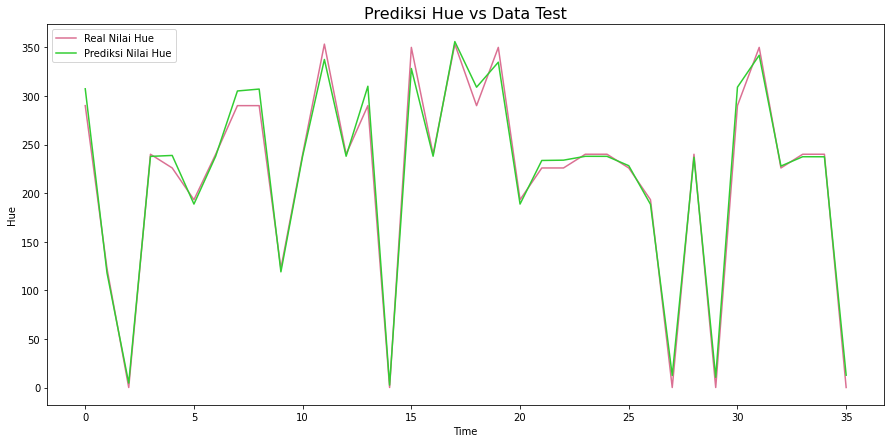

In [ ]:
# Membuat diagram garis untuk memperlihatkan ke akuratan hasil prediksi dan nilai real pada dataset
# Data prediksi vs data test

plt.figure(figsize=(15,7))
plt.plot(compare2['hue'], color = 'palevioletred', label = 'Real Nilai Hue')
plt.plot(compare2['pred'], color = 'limegreen', label = 'Prediksi Nilai Hue')
plt.title('Prediksi Hue vs Data Test',fontsize = 16)
plt.xlabel('Time')
plt.ylabel('Hue')
plt.legend()
plt.show()

In [ ]:
X_test1 = X_test1.reset_index(drop=True)
df2 = [X_test1, compare2]

df3 = pd.concat(df2, axis=1)
df3.rename(columns={'brightness': 'value'}, inplace=True)
df3.head(2)

,saturation,value,minggu ke,Total PO Order Qty,Year,Month,Season,range_warna,hue,pred
0,9.836066,23.921569,1,7000,2020,6,2,9,290.000000,307.342
1,35.678392,78.039216,2,1613,2020,6,2,5,122.535211,118.005


In [ ]:
df3['saturation'] = df3['saturation'].div(100).round(2)
df3['value'] = df3['value'].div(100).round(2)

In [ ]:
plot1 = df3[['hue', 'saturation','value']]
plot2 = df3[['pred', 'saturation','value']]
plot2.rename(columns={'pred': 'pred_hue'}, inplace=True)

In [ ]:
print(plot2.head(2))
print(plot1.head(2))

  pred_hue  saturation  value
0  307.342        0.10   0.24
1  118.005        0.36   0.78
          hue  saturation  value
0  290.000000        0.10   0.24
1  122.535211        0.36   0.78


In [ ]:
plot1['hsv'] = [', '.join(str(x) for x in y) for y in map(tuple, plot1[['hue', 'saturation', 'value']].values)]
plot2['hsv'] = [', '.join(str(x) for x in y) for y in map(tuple, plot2[['pred_hue', 'saturation', 'value']].values)]
print(plot1.head(2))
print(plot2.head(2))

          hue  saturation  value                            hsv
0  290.000000        0.10   0.24   289.9999999999999, 0.1, 0.24
1  122.535211        0.36   0.78  122.5352112676056, 0.36, 0.78
  pred_hue  saturation  value                             hsv
0  307.342        0.10   0.24    307.3415222167969, 0.1, 0.24
1  118.005        0.36   0.78  118.00450134277344, 0.36, 0.78


In [ ]:
decimals = 2    
plot1['hue'] = plot1['hue'].apply(lambda x: round(x, decimals))
plot1['saturation'] = plot1['saturation'].apply(lambda x: round(x, decimals))
plot1['value'] = plot1['value'].apply(lambda x: round(x, decimals))

plot2['hue'] = plot2['pred_hue'].apply(lambda x: round(x, decimals))
plot2['saturation'] = plot2['saturation'].apply(lambda x: round(x, decimals))
plot2['value'] = plot2['value'].apply(lambda x: round(x, decimals))

In [ ]:
print(plot1.head(2))
print(plot2.head(2))

      hue  saturation  value                            hsv
0  290.00        0.10   0.24   289.9999999999999, 0.1, 0.24
1  122.54        0.36   0.78  122.5352112676056, 0.36, 0.78
  pred_hue  saturation  value                             hsv     hue
0  307.342        0.10   0.24    307.3415222167969, 0.1, 0.24  307.34
1  118.005        0.36   0.78  118.00450134277344, 0.36, 0.78  118.00


In [ ]:
def hsv_to_rgb(h, s, v):
    if s == 0.0: v*=255; return (v, v, v)
    i = int(h*6.) # XXX assume int() truncates!
    f = (h*6.)-i; p,q,t = int(255*(v*(1.-s))), int(255*(v*(1.-s*f))), int(255*(v*(1.-s*(1.-f)))); v*=255; i%=6
    if i == 0: return (v, t, p)
    if i == 1: return (q, v, p)
    if i == 2: return (p, v, t)
    if i == 3: return (p, q, v)
    if i == 4: return (t, p, v)
    if i == 5: return (v, p, q)

import colorsys
def hsv2rgb(h,s,v):
    return tuple(round(i * 255) for i in colorsys.hsv_to_rgb(h,s,v))

In [ ]:
# h = plot1['hue'][0]
# s= plot1['saturation'][0]
# v= plot1['value'][0]
# print(h)
# print(s)
# print(v)
# print(hsv_to_rgb(h, s, v))
# print(hsv2rgb(0, 0, 0.69))
# print(hsv_to_rgb(0,0,0.69))

In [ ]:
real_rgb = []
for z in range (len(plot1)) :
    h = plot1['hue'][z]
    s = plot1['saturation'][z]
    v = plot1['value'][z]
    #print(x)
    rgb_cols = hsv2rgb(h, s, v)
    real_rgb.append(rgb_cols)

print(len(real_rgb))

pred_rgb = []
for zz in range (len(plot2)) :
    h = plot2['pred_hue'][zz]
    s = plot2['saturation'][zz]
    v = plot2['value'][zz]
    #print(x)
    rgb_cols = hsv2rgb(h, s, v)
    pred_rgb.append(rgb_cols)
print(len(pred_rgb))

36
36


In [ ]:
#real_rgb

In [ ]:
#pred_rgb

In [ ]:
# real warna
# for i in range(len(real_rgb)):
#     plt.figure()
#     plt.imshow([[real_rgb[i]]])
#     #plt.savefig("/content/drive/MyDrive/warna_pred_real/real/real_color" + str(i) +".png", format="PNG")
#     # Show/save figure as desired.
#     plt.show()

In [ ]:
# pred warna
# for i in range(len(pred_rgb)):
#     plt.figure()
#     plt.imshow([[pred_rgb[i]]])
#     #plt.savefig("/content/drive/MyDrive/warna_pred_real/pred/pred_color" + str(i) +".png", format="PNG")
#     # Show/save figure as desired.
#     plt.show()

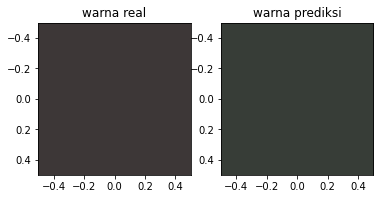

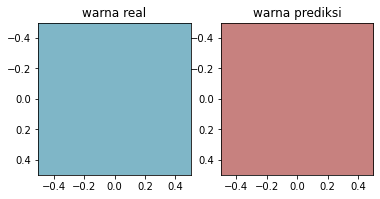

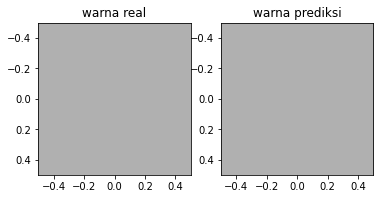

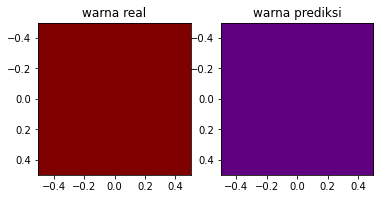

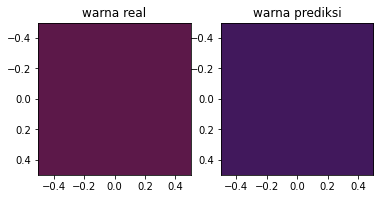

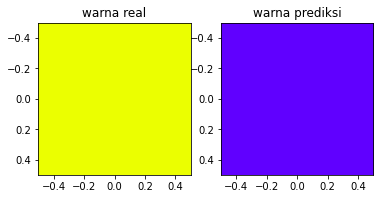

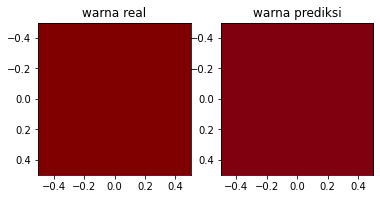

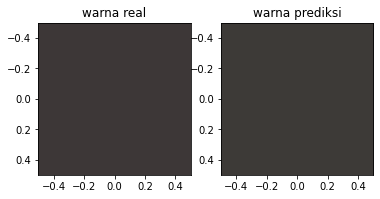

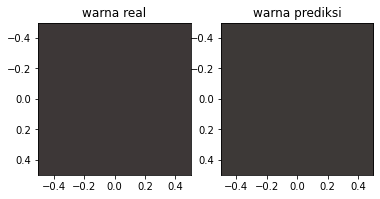

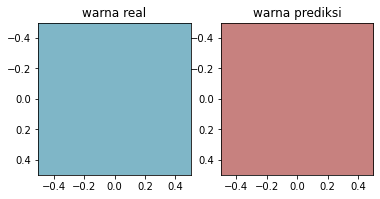

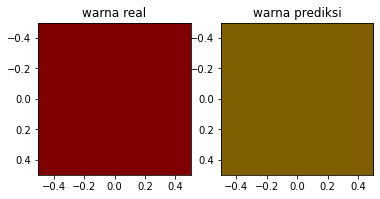

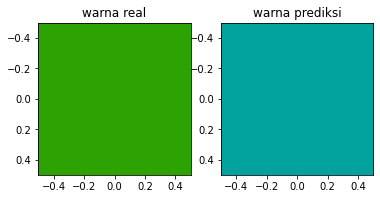

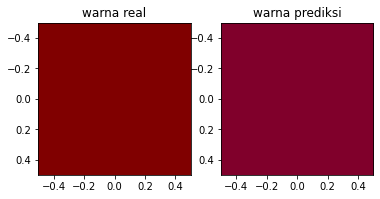

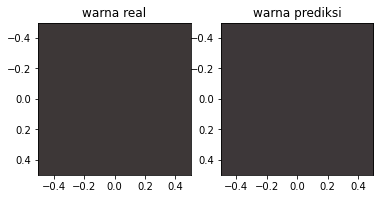

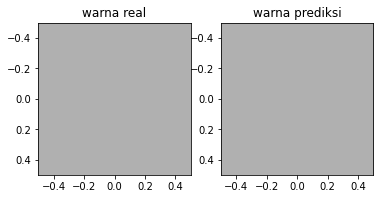

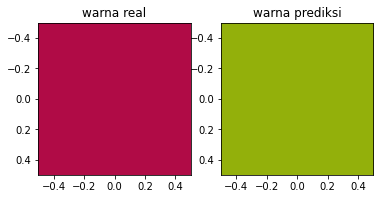

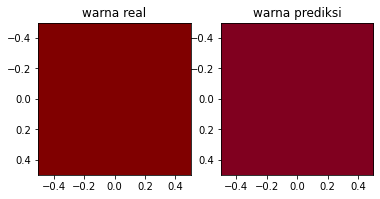

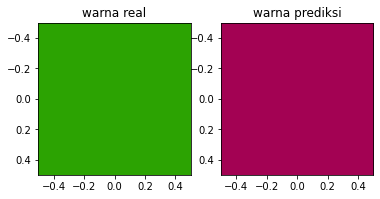

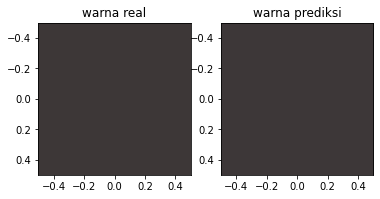

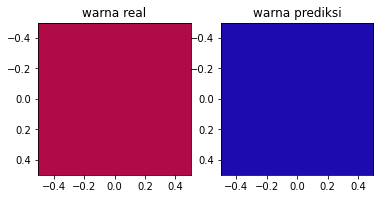

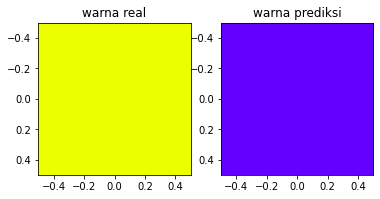

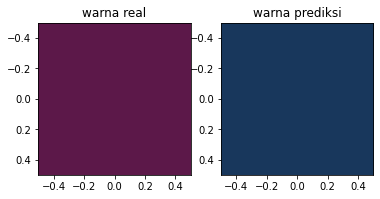

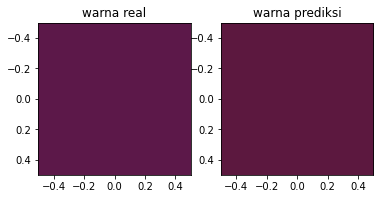

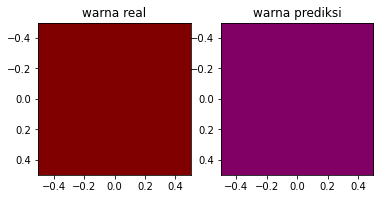

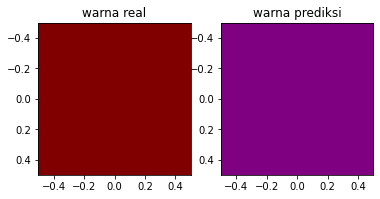

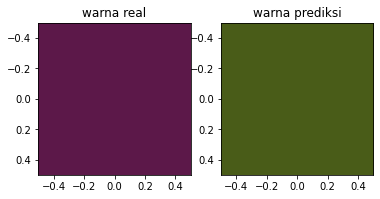

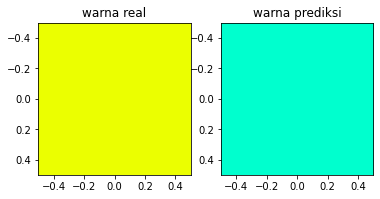

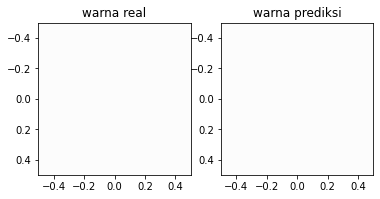

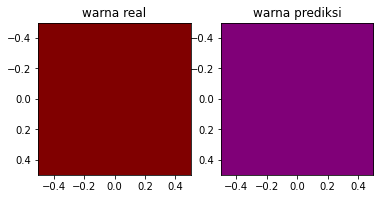

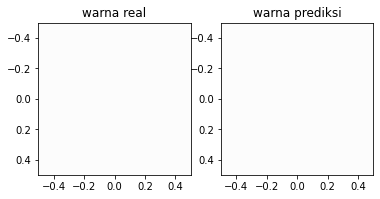

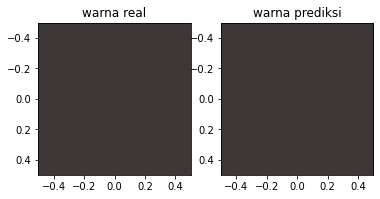

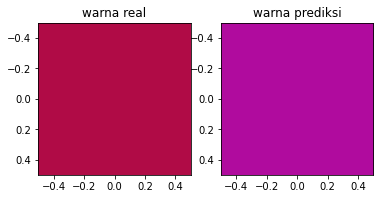

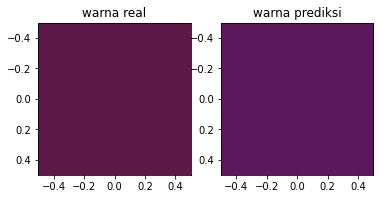

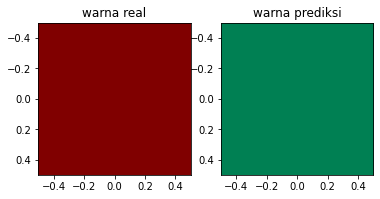

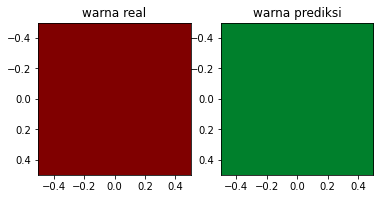

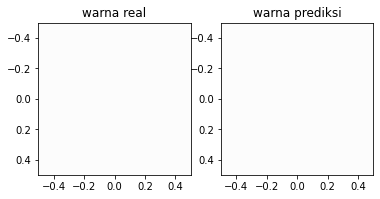

In [ ]:
for i in range(len(real_rgb)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('warna real')
    ax2.title.set_text('warna prediksi')
    ax1.imshow([[real_rgb[i]]])
    ax2.imshow([[pred_rgb[i]]])
    plt.show()

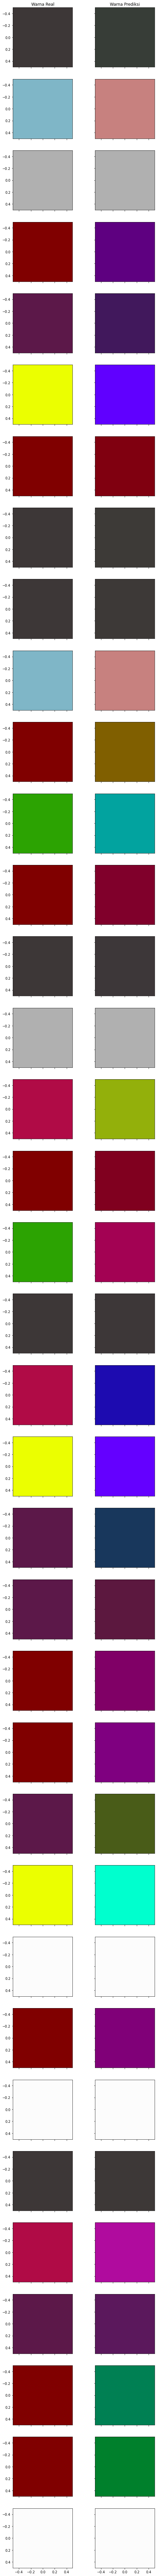

In [ ]:
fig, ax = plt.subplots(36, 2, sharex='col', sharey='row',figsize=(8, 140))

ax[0, 0].title.set_text('Warna Real')
ax[0, 1].title.set_text('Warna Prediksi')

for i in range(36):
    ax[i, 1].imshow([[pred_rgb[i]]])
    ax[i, 0].imshow([[real_rgb[i]]])

In [ ]:
def predclass(row):
    if row['pred'] < 0.5 :
        val = 0
    elif row['pred'] <= 15 :
        val = 1
    elif row['pred'] <= 45 :
        val = 2
    elif row['pred'] <= 75 :
        val = 3
    elif row['pred'] <= 115 :
        val = 4
    elif row['pred'] <= 165 :
        val = 5
    elif row['pred'] <= 195 :
        val = 6
    elif row['pred'] <= 255 :
        val = 7
    elif row['pred'] <= 285 :
        val = 8
    elif row['pred'] <= 315 :
        val = 9
    elif row['pred'] <= 345 :
        val = 10
    else:
        val = 1
    return val

In [ ]:
compare['kelas asli'] = compare.apply(rc, axis=1)
compare['kelas pred'] = compare.apply(predclass, axis=1)
compare

,hue,pred,kelas asli,kelas pred
0,290.000000,307.342,9,9
1,122.535211,118.005,5,5
2,0.000000,4.57884,0,1
3,240.000000,237.789,7,7
4,225.882353,238.766,7,7
5,193.176471,188.729,6,6
6,240.000000,237.98,7,7
7,290.000000,305.091,9,9
8,290.000000,307.049,9,9
9,122.535211,119.004,5,5


In [ ]:
def cek(row):
  if row['kelas asli'] == row['kelas pred'] :
    x = 'true'
  else :
    x = 'false'
  return x

compare['check'] = compare.apply(cek, axis=1)

In [ ]:
compare

,hue,pred,kelas asli,kelas pred,check
0,290.000000,307.342,9,9,true
1,122.535211,118.005,5,5,true
2,0.000000,4.57884,0,1,false
3,240.000000,237.789,7,7,true
4,225.882353,238.766,7,7,true
5,193.176471,188.729,6,6,true
6,240.000000,237.98,7,7,true
7,290.000000,305.091,9,9,true
8,290.000000,307.049,9,9,true
9,122.535211,119.004,5,5,true


In [ ]:
compare.to_excel("Hasil_Testing.xlsx")

In [ ]:
clist = compare['check'].values.tolist()
acc = (clist.count('true') / len(compare)) * 100
acc

75.0

# Menyimpan Model

In [ ]:
model.save_weights('weight_modelv2.h5')
model.save('my_modelv2.h5')

# Load Model dan Uji Model

In [4]:
from keras.models import load_model
 
# load model
#loaded_model = load_model('/content/drive/MyDrive/folder_model_bu_yuli/model_dan_berat/my_model.h5')
model = load_model('/content/drive/MyDrive/folder_model_bu_yuli/model_dan_berat/my_model.h5')
model.load_weights('/content/drive/MyDrive/folder_model_bu_yuli/model_dan_berat/weight_model.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [35]:
x_testdep = pd.read_excel('/content/drive/MyDrive/folder_model_bu_yuli/x_testVarDeploy.xlsx')
y_testdep = pd.read_excel('/content/drive/MyDrive/folder_model_bu_yuli/y_testVarDeploy.xlsx')

x_testdep.drop('Unnamed: 0', axis=1, inplace=True)
y_testdep.drop('Unnamed: 0', axis=1, inplace=True)

In [36]:
x_testdep.head(2)


,saturation,brightness,minggu ke,Total PO Order Qty,Year,Month,Season,range_warna
0,9.836066,23.921569,1,2000,2021,1,4,9
1,100.000000,50.000000,2,5130,2021,1,4,7


In [37]:
y_testdep.head(2)

,hue
0,290.0
1,240.0


Normalisasi Data Deploy

In [38]:
sc = StandardScaler()
X_test1 = x_testdep
X_test = sc.fit_transform(x_testdep)

## Predict Data Deploy

In [39]:
predictDeploy = np.minimum(360., np.maximum(0, model.predict(X_test)))

In [40]:
rmse = mean_squared_error(y_testdep, predictDeploy, squared=False)

print(rmse)

23.030432090255623


In [41]:
# Menjadikan hasil prediksi dan real value menjadi series 

predictDeploy = predictDeploy.tolist()
predictDeploy = pd.Series(predictDeploy)
predictDeploy = predictDeploy.explode()
print(predictDeploy)

y_testdep = y_testdep.squeeze()
print(y_testdep)

0     335.008
1     235.782
2     194.091
3     223.884
4     216.505
5     234.907
6     334.507
7     194.407
8     215.367
9     193.838
10    236.862
11          0
12    216.299
13    194.253
14          0
15    235.606
16    216.258
17    193.287
18    233.464
19    245.825
20    333.131
21    117.461
22          0
23    234.195
24     219.26
25    192.006
26    233.184
27    331.772
28    333.882
29    116.363
30    231.857
31    335.535
32    232.945
33    329.689
34          0
35    338.066
36      233.9
37        360
38    331.489
39    355.513
40    192.828
41    214.426
42    217.638
43    234.135
44    233.802
45    214.428
46    192.278
47          0
dtype: object
0     290.000000
1     240.000000
2     193.176471
3     225.882353
4     225.882353
5     240.000000
6     290.000000
7     193.176471
8     225.882353
9     193.176471
10    240.000000
11      0.000000
12    225.882353
13    193.176471
14      0.000000
15    240.000000
16    225.882353
17    193.176471
18    24

## Visualisasi Perbandingan Prediksi vs Real

In [42]:
# Komparasi kedua hasil
compare = pd.DataFrame({'hue' : y_testdep, 'pred' : predictDeploy})

print(compare)

           hue     pred
0   290.000000  335.008
1   240.000000  235.782
2   193.176471  194.091
3   225.882353  223.884
4   225.882353  216.505
5   240.000000  234.907
6   290.000000  334.507
7   193.176471  194.407
8   225.882353  215.367
9   193.176471  193.838
10  240.000000  236.862
11    0.000000        0
12  225.882353  216.299
13  193.176471  194.253
14    0.000000        0
15  240.000000  235.606
16  225.882353  216.258
17  193.176471  193.287
18  240.000000  233.464
19  349.940120  245.825
20  290.000000  333.131
21  122.535211  117.461
22    0.000000        0
23  240.000000  234.195
24  225.882353   219.26
25  193.176471  192.006
26  240.000000  233.184
27  290.000000  331.772
28  290.000000  333.882
29  122.535211  116.363
30  240.000000  231.857
31  353.291925  335.535
32  240.000000  232.945
33  290.000000  329.689
34    0.000000        0
35  349.940120  338.066
36  240.000000    233.9
37  353.291925      360
38  290.000000  331.489
39  349.940120  355.513
40  193.176471  

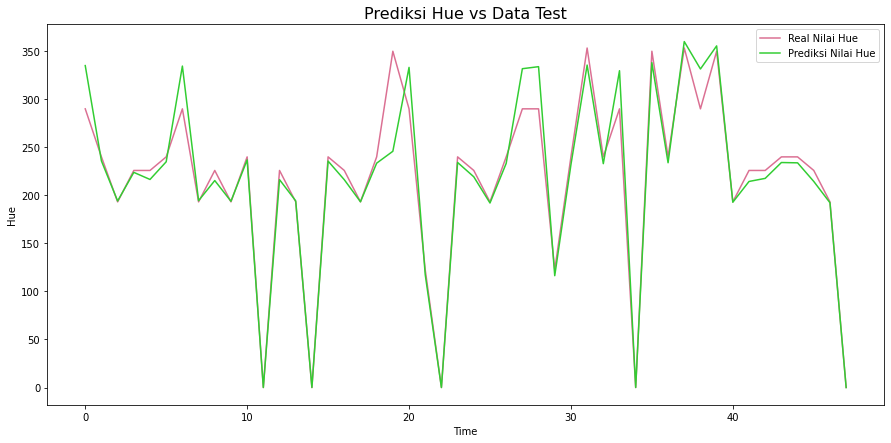

In [43]:
# Membuat diagram garis untuk memperlihatkan ke akuratan hasil prediksi dan nilai real pada dataset
# Data prediksi vs data test

plt.figure(figsize=(15,7))
plt.plot(compare['hue'], color = 'palevioletred', label = 'Real Nilai Hue')
plt.plot(compare['pred'], color = 'limegreen', label = 'Prediksi Nilai Hue')
plt.title('Prediksi Hue vs Data Test',fontsize = 16)
plt.xlabel('Time')
plt.ylabel('Hue')
plt.legend()
plt.show()

## Akurasi citra berdasarkan Range Kelas

In [54]:
# Fungsi membuat range pada nilai prediksi

def rc(row):
    if row['hue'] < 0.5 :
        val = 0
    elif row['hue'] <= 15 :
        val = 1
    elif row['hue'] <= 45 :
        val = 2
    elif row['hue'] <= 75 :
        val = 3
    elif row['hue'] <= 115 :
        val = 4
    elif row['hue'] <= 165 :
        val = 5
    elif row['hue'] <= 195 :
        val = 6
    elif row['hue'] <= 255 :
        val = 7
    elif row['hue'] <= 285 :
        val = 8
    elif row['hue'] <= 315 :
        val = 9
    elif row['hue'] <= 345 :
        val = 10
    else:
        val = 1
    return val

def predclass(row):
    if row['pred'] < 0.5 :
        val = 0
    elif row['pred'] <= 15 :
        val = 1
    elif row['pred'] <= 45 :
        val = 2
    elif row['pred'] <= 75 :
        val = 3
    elif row['pred'] <= 115 :
        val = 4
    elif row['pred'] <= 165 :
        val = 5
    elif row['pred'] <= 195 :
        val = 6
    elif row['pred'] <= 255 :
        val = 7
    elif row['pred'] <= 285 :
        val = 8
    elif row['pred'] <= 315 :
        val = 9
    elif row['pred'] <= 345 :
        val = 10
    else:
        val = 1
    return val

In [58]:
compare['kelas_asli'] = compare.apply(rc, axis=1)
compare['kelas_pred'] = compare.apply(predclass, axis=1)
compare

,hue,pred,kelas_asli,kelas_pred
0,290.000000,335.008,9,10
1,240.000000,235.782,7,7
2,193.176471,194.091,6,6
3,225.882353,223.884,7,7
4,225.882353,216.505,7,7
5,240.000000,234.907,7,7
6,290.000000,334.507,9,10
7,193.176471,194.407,6,6
8,225.882353,215.367,7,7
9,193.176471,193.838,6,6


In [62]:
def cek(row):
  if row['kelas_asli'] == row['kelas_pred'] :
    x = 'true'
  else :
    x = 'false'
  return x

compare['check'] = compare.apply(cek, axis=1)

compare

,hue,pred,kelas_asli,kelas_pred,check
0,290.000000,335.008,9,10,false
1,240.000000,235.782,7,7,true
2,193.176471,194.091,6,6,true
3,225.882353,223.884,7,7,true
4,225.882353,216.505,7,7,true
5,240.000000,234.907,7,7,true
6,290.000000,334.507,9,10,false
7,193.176471,194.407,6,6,true
8,225.882353,215.367,7,7,true
9,193.176471,193.838,6,6,true


In [65]:
compare.to_excel("Hasil_Testing_Deploy.xlsx")

In [64]:
clist = compare['check'].values.tolist()
acc = (clist.count('true') / len(compare)) * 100
acc

79.16666666666666

## Pembuatan Visualisasi Citra Warna Prediksi dan Real

In [46]:
df = [X_test1, compare]

df1 = pd.concat(df, axis=1)
df1.rename(columns={'brightness': 'value'}, inplace=True)
df1['saturation'] = df1['saturation'].div(100).round(2)
df1['value'] = df1['value'].div(100).round(2)
df1.head(2)

,saturation,value,minggu ke,Total PO Order Qty,Year,Month,Season,range_warna,hue,pred
0,0.1,0.24,1,2000,2021,1,4,9,290.0,335.008
1,1.0,0.50,2,5130,2021,1,4,7,240.0,235.782


In [48]:
plot1 = df1[['hue', 'saturation','value']]
plot2 = df1[['pred', 'saturation','value']]
plot2.rename(columns={'pred': 'pred_hue'}, inplace=True)

print(plot2.head(2))
print(plot1.head(2))

  pred_hue  saturation  value
0  335.008         0.1   0.24
1  235.782         1.0   0.50
     hue  saturation  value
0  290.0         0.1   0.24
1  240.0         1.0   0.50


In [49]:
# Fungsi HSV to RGB

import colorsys
def hsv2rgb(h,s,v):
    return tuple(round(i * 255) for i in colorsys.hsv_to_rgb(h,s,v))

In [50]:
real_rgb = []
for z in range (len(plot1)) :
    h = plot1['hue'][z]
    s = plot1['saturation'][z]
    v = plot1['value'][z]
    #print(x)
    rgb_cols = hsv2rgb(h, s, v)
    real_rgb.append(rgb_cols)

print(len(real_rgb))

pred_rgb = []
for zz in range (len(plot2)) :
    h = plot2['pred_hue'][zz]
    s = plot2['saturation'][zz]
    v = plot2['value'][zz]
    #print(x)
    rgb_cols = hsv2rgb(h, s, v)
    pred_rgb.append(rgb_cols)
print(len(pred_rgb))

48
48


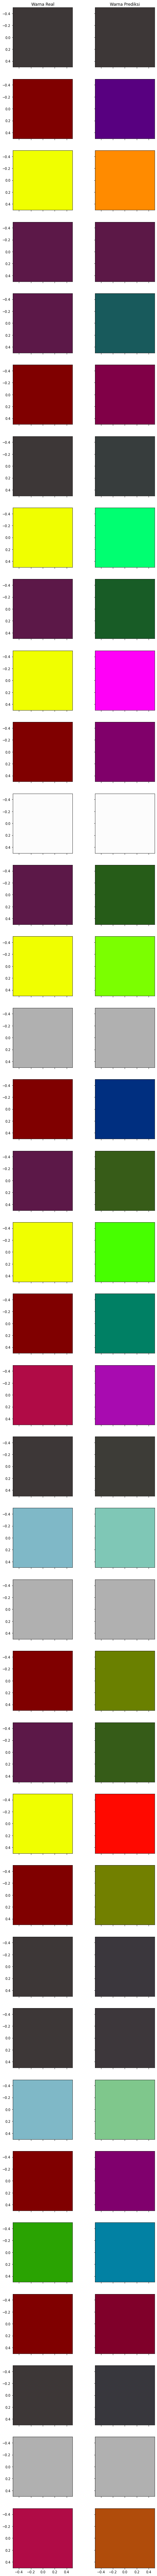

In [51]:
fig, ax = plt.subplots(36, 2, sharex='col', sharey='row',figsize=(8, 140))

ax[0, 0].title.set_text('Warna Real')
ax[0, 1].title.set_text('Warna Prediksi')

for i in range(36):
    ax[i, 1].imshow([[pred_rgb[i]]])
    ax[i, 0].imshow([[real_rgb[i]]])